# Multi-class Linear Support Vector Machine

## Tasks: 
* Implement the function to compute the loss and gradient for multi-class linear SVM with the bias trick. (the "svm_loss_forloop" function in linear_svm.py)
* Understand how to speed the computation with vectorized implementation (the "svm_loss_vectorized" function in linear_svm.py)
* Implement Stochastic Gradient Descent in "LinearSVM.train" and the predict function "LinearSVM.predict" in linear_svm.py
* Find the optimal learning rate and regularization weight using validation set (In this notebook)

## Notice:
There are a couple of new files we need for this week.
* You need to download and unzip this [classifiers](https://drive.google.com/open?id=0B2Yvyjb5-_OgQ29PTzcwRWN0cEE) folder into the "notebooks" folder. So it looks as "notebooks/classifiers/"
* You need to download this ["gradient_check.py"](https://drive.google.com/open?id=0B2Yvyjb5-_OgWjVhdVh2NWN1bVU) file and add it to "notebooks/utils". This is a great piece of code from the Stanford CS231n class for comparing analytical gradient with numerical gradient.

# Setup

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from utils.data_utils import load_CIFAR10
from classifiers.linear_svm import svm_loss_bias_forloop
from classifiers.linear_svm import svm_loss_forloop
from classifiers.linear_svm import svm_loss_vectorized
from utils.gradient_check import grad_check_sparse
from classifiers.linear_svm import LinearSVM

import time

# Some magic so that the notebook will automatically reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# CIFAR-10 Data Loading and Preprocessing

In [3]:
# Load the raw CIFAR-10 data.
cifar10_dir = '../opt/data/datasets/cifar-10-batches-py'
print('Loading CIFAR10 ...')
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print 'Training data shape: ', X_train.shape
print 'Training labels shape: ', y_train.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

Loading CIFAR10 ...
Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


In [4]:
# Subsample the data for more efficient code execution in this exercise.
num_training = 2000
num_validation = 100
num_test = 100

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))

# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image

Train data shape:  (2000, 32, 32, 3)
Train labels shape:  (2000,)
Validation data shape:  (100, 32, 32, 3)
Validation labels shape:  (100,)
Test data shape:  (100, 32, 32, 3)
Test labels shape:  (100,)


# Some warm up

In [5]:
# Compute multi-class SVM loss and gradient with the given svm_loss_bias_forloop
# We just use some random weights here
W = np.random.randn(3072, 10) * 0.0001
b = np.random.randn(10) * 0.0001
loss, grad_W, grad_b = svm_loss_bias_forloop(W, b, X_train, y_train, 0.00001)
print 'loss : %f ' % loss

loss : 9.168862 


In [6]:
# Here we check the analaytic gradient by comparing it to the numerical gradient
# "grad_check_sparse" numerically computes the gradient along several randomly chosen dimensions, and
# compute with difference with the analytical gradient from svm_loss_bias_forloop. 
# understand how this is implemented in utils/gradient_check.py

loss, grad_W, grad_b = svm_loss_bias_forloop(W, b, X_train, y_train, 0.00001)
f = lambda W: svm_loss_bias_forloop(W, b, X_train, y_train, 0.00001)[0]
tic = time.time()
grad_numerical = grad_check_sparse(f, W, grad_W, 5)
toc = time.time()
print 'grad_check_sparse W in %fs' % (toc - tic)

numerical: -19.569181 analytic: -19.560742, relative error: 2.156783e-04
numerical: 1.180990 analytic: 1.180990, relative error: 5.983824e-10
numerical: 22.827023 analytic: 22.827023, relative error: 5.019084e-11
numerical: -0.564451 analytic: -0.581554, relative error: 1.492431e-02
numerical: 25.263858 analytic: 25.293468, relative error: 5.856612e-04
grad_check_sparse W in 7.353742s


# Task 1: Implement your own computation for loss & gradient with the Bias Trick

In [7]:
# To use the bias trick, we simply append the bias dimension of ones so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
print X_train.shape
print X_val.shape
print X_test.shape

(2000, 3073)
(100, 3073)
(100, 3073)


In [9]:
# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

# Implement svm_loss_forloop in classifiers/linear_svm.py
# You are allowed to use forloop (as in svm_loss_bias_forloop)
tic = time.time()
loss, grad = svm_loss_forloop(W, X_train, y_train, 0.00001)
toc = time.time()
t_forloop = toc - tic

print loss
print t_forloop


8.72796010336
1.30206799507


In [13]:
# check your loss
# svm_loss_vectorized is a given fast (vectorized) implementation
# you svm_loss_forloop function should return the same result (but slower) 
tic = time.time()
loss_vectorized, grad_vectorized = svm_loss_vectorized(W, X_train, y_train, 0.00001)
toc = time.time()
t_vectorized = toc - tic

# Correct implemention will give zero difference
print "loss : %f, loss_vectorized: %f, difference: %f" % (loss, loss_vectorized, loss - loss_vectorized)
# Notice vectorized implementation will give significant speed up
print "time forloop: %f, time_vectorized: %f" % (t_forloop, t_vectorized)

loss : 8.727960, loss_vectorized: 8.727960, difference: -0.000000
time forloop: 1.302068, time_vectorized: 0.102708


In [21]:
# Check your gradient
# you should see small relative error
loss, grad = svm_loss_forloop(W, X_train, y_train, 0.00001)
f = lambda w: svm_loss_forloop(w, X_train, y_train, 0.00001)[0]
tic = time.time()
grad_numerical = grad_check_sparse(f, W, grad, 5)
toc = time.time()
print 'grad_check_sparse in %fs' % (toc - tic)

numerical: -20.058519 analytic: -20.058519, relative error: 1.228460e-11
numerical: -1.263621 analytic: -1.263621, relative error: 1.094111e-10
numerical: 24.601620 analytic: 24.593770, relative error: 1.595627e-04
numerical: -0.418794 analytic: -0.415820, relative error: 3.563203e-03
numerical: 16.956550 analytic: 16.970243, relative error: 4.035759e-04
grad_check_sparse in 7.012438s


# Task 2: Vectorized Implementation

**Check the vectorized implementation (svm_loss_vectorized) in classifiers/linear_svm**

**In particular, make sure you can explain how broadcasting and advance indexing are used.**

# Task 3: Implement Stochastic Gradient Descent

In [28]:
# Now implement the LinearSVM.train() in classifiers/linear_svm.py
# It does stochastic gradient descent
# Run it with the code below
# You should see the loss decrease with numbers of interations
svm = LinearSVM()
tic = time.time() 
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=5e4,
                      num_iters=2000, verbose=True)  
toc = time.time()
print 'Time spent %fs' % (toc - tic)

iteration 0 / 2000: loss 774.480027
iteration 100 / 2000: loss 283.141195
iteration 200 / 2000: loss 106.153799
iteration 300 / 2000: loss 41.150232
iteration 400 / 2000: loss 17.914800
iteration 500 / 2000: loss 9.488656
iteration 600 / 2000: loss 6.123820
iteration 700 / 2000: loss 5.308577
iteration 800 / 2000: loss 4.683772
iteration 900 / 2000: loss 4.502443
iteration 1000 / 2000: loss 4.331246
iteration 1100 / 2000: loss 4.619391
iteration 1200 / 2000: loss 5.023363
iteration 1300 / 2000: loss 4.751040
iteration 1400 / 2000: loss 4.560448
iteration 1500 / 2000: loss 4.285350
iteration 1600 / 2000: loss 4.647739
iteration 1700 / 2000: loss 4.211517
iteration 1800 / 2000: loss 4.569618
iteration 1900 / 2000: loss 4.262791
Time spent 21.848765s


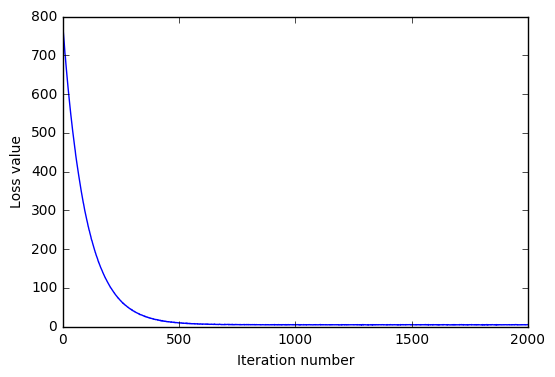

In [29]:
# You can also lot the loss as a function of iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [26]:
# Implement the LinearSVM.predict() function in classifiers/linear_svm.py 
# use this block of code to evaluate your classifier on both the training and validation set. 
# You should get around 0.40 accuracy on the training set and 0.34 accuracy on the validation set
y_train_pred = svm.predict(X_train)
print 'training accuracy: %f' % (np.mean(y_train == y_train_pred), )
y_val_pred = svm.predict(X_val)
print 'validation accuracy: %f' % (np.mean(y_val == y_val_pred), )

training accuracy: 0.484500
validation accuracy: 0.270000


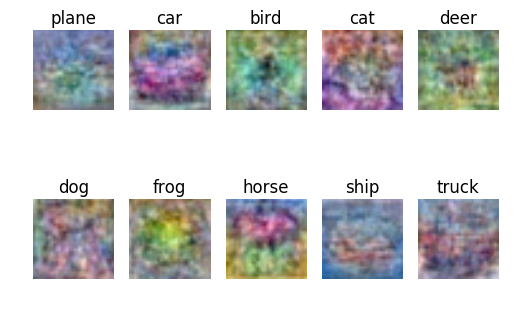

In [27]:
# You can also visualize the weights in the learned SVM
w = svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])
plt.show()

# Task 4: Hyper-Parameters (learninng rate and regularization strength)

Now let see how to choose the best "learning_rate" and "reg" for the training.

In [ ]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [1e-7, 2e-7, 3e-7, 5e-5, 8e-7]
regularization_strengths = [1e4, 2e4, 3e4, 4e4, 5e4, 6e4, 7e4, 8e4, 1e5]
num_iters=500 

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.
best_lr = 0
best_reg = 0

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################

for lr in learning_rates:
    for rs in regularization_strengths:
        svm = LinearSVM()
        # your code 
        svm.train(X_train, y_train, learning_rate=lr, reg=rs,
                      num_iters=num_iters, verbose=False)
        y_train_pred = svm.predict(X_train)
        y_val_pred = svm.predict(X_val)
        acc_train = np.mean(y_train == y_train_pred)
        acc_val = np.mean(y_val == y_val_pred)
        
        if acc_val > best_val:
            best_val, best_lr, best_reg = acc_val, lr, rs
        
        
        
        
print 'best validation accuracy achieved during cross-validation: %f' % best_val
print 'with learning rate %f, regularization strength %f' % (best_lr, best_reg)


################################################################################
#                              END OF YOUR CODE                                #
################################################################################



In [33]:
# Now train with more interations with the optimal parameters
svm = LinearSVM()
tic = time.time() 
loss_hist = svm.train(X_train, y_train, learning_rate=best_lr, reg=best_reg,
                      num_iters=2000, verbose=True)  
toc = time.time()
print 'Time spent %fs' % (toc - tic)

iteration 0 / 2000: loss 333.100149
iteration 100 / 2000: loss 97.014922
iteration 200 / 2000: loss 32.221189
iteration 300 / 2000: loss 13.201433
iteration 400 / 2000: loss 7.329346
iteration 500 / 2000: loss 5.801721
iteration 600 / 2000: loss 5.114188
iteration 700 / 2000: loss 5.649691
iteration 800 / 2000: loss 5.046511
iteration 900 / 2000: loss 5.168910
iteration 1000 / 2000: loss 5.518989
iteration 1100 / 2000: loss 5.218977
iteration 1200 / 2000: loss 4.877820
iteration 1300 / 2000: loss 4.862578
iteration 1400 / 2000: loss 5.249252
iteration 1500 / 2000: loss 5.324712
iteration 1600 / 2000: loss 5.458653
iteration 1700 / 2000: loss 5.073962
iteration 1800 / 2000: loss 4.925132
iteration 1900 / 2000: loss 5.301325
Time spent 7.704544s


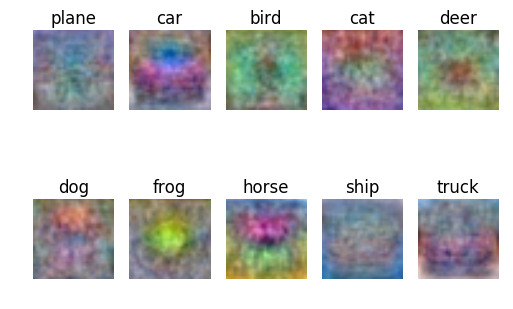

training accuracy: 0.372150
validation accuracy: 0.356000
testing accuracy: 0.364000


In [34]:
# Visualize W

w = svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])
plt.show()

y_train_pred = svm.predict(X_train)
print 'training accuracy: %f' % (np.mean(y_train == y_train_pred), )
y_val_pred = svm.predict(X_val)
print 'validation accuracy: %f' % (np.mean(y_val == y_val_pred), )
y_test_pred = svm.predict(X_test)
print 'testing accuracy: %f' % (np.mean(y_test == y_test_pred), )

# Task 5: Test with more data

In [27]:
# Congradulations! You just implement the entire classification pipeline on your own!!!
# It is truly amazing that we are able to achieve around 36% accuracy 
# This is over 25% increasement from random guess (10 classes)
# Now try to re-trian your SVM with more data by setting larger values to the following three variables
num_training = 20000
num_validation = 1000
num_test = 1000